## Twitter Dataset Prepare

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import tqdm
import regex
import os
import re
import shutil
import operator
import codecs
import time
import random
from math import log
from nltk import sent_tokenize
from pymystem3 import Mystem
from seaborn import heatmap
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import RussianStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV



from sklearn.ensemble import GradientBoostingClassifier
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

%matplotlib inline

База данных состоит из 12 столбцов:
- id: уникальный номер сообщения в системе twitter;
- tdate: дата публикации сообщения (твита);
- tmane: имя пользователя, опубликовавшего сообщение;
- ttext:  текст сообщения (твита);
- ttype: поле в котором в дальнейшем будет указано к кому классу относится твит (положительный, отрицательный, нейтральный);
- trep: количество реплаев к данному сообщению. В настоящий момент API твиттера не отдает эту информацию;
- trtf: число ретвитов
- tfav: число сколько раз данное сообщение было добавлено в избранное другими пользователями;
- tstcount: число всех сообщений пользователя в сети twitter;
- tfol: количество фоловеров пользователя (тех людей, которые читают пользователя);
- tfrien: количество друзей пользователя (те люди, которых читает пользователь);
- listcount: количество листов-подписок в которые добавлен твиттер-пользователь.

In [2]:
header = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'trtf', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount']

#### Загружаем положительные и негативные твиты в один DataFrame, после этого перемешиваем с помощью sample(frac=1)

In [3]:
pos_twitts = pd.read_csv('dataset/train_positive.csv', sep=';', names=header)
neg_twitts = pd.read_csv('dataset/train_negative.csv', sep=';', names=header)
twitts = pd.concat([pos_twitts, neg_twitts], axis=0)
twitts = twitts.sample(frac=1)

#### Смотрим размерность нашего размеченного датасета и проверяем, что у нас 2 вида твитов(положительные(1) и негативные(-1))

In [4]:
print twitts.shape
twitts.head()

(226834, 12)


,id,tdate,tmane,ttext,ttype,trep,trtf,tfav,tstcount,tfol,tfrien,listcount
32861,409753229212135424,1386527757,narrator_tyler,"@Blink_Milk РАССКАЗЧИИИИК ^____^ мр :з\nну,ког...",1,0,0,0,7999,70,62,1
70084,410466056969654272,1386697708,19LUCHS69,@petr7070 @Trochenco великолепная фраза ) На у...,1,0,0,0,80454,1386,584,64
24754,409549331466027008,1386479144,karpin1994,RT @lys_mila: Замечательный вечер и ночь..все ...,1,0,1,0,2614,67,80,0
105288,424098839247990784,1389948017,truniova,@_WhenDoWeStart мне еще сегодня идти брать инт...,-1,0,0,0,9575,823,451,9
70183,410466817732542464,1386697890,ereizer1,"@sabbathist @suselll надо же, есть люди, котор...",1,0,0,0,5985,161,170,6


In [5]:
twitts.ttype.unique()

array([ 1, -1], dtype=int64)

## Working with Twitter texts

In [6]:
X = twitts.ttext.values
y = twitts.ttype.values

In [7]:
def prepare_text(text):
    text = text.lower().strip()
    text = ' '.join(text.split())
    text = re.sub(r'@\S+', '', text) # delete @user_name
    text = re.sub(r'#\W+', '', text) # delete #hashtag
    text = re.sub(r'[\!\"\#\$\%\&\\\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\\\]\^\_\`\{\|\}\~, a-z, 0-9]+', ' ', text) # delete smiles
    return text

def tokenize(text):
    tokenizer = RegexpTokenizer('\w+|\S+')
    return tokenizer.tokenize(text)

def stem_text(text):
    r = RussianStemmer()
    return [r.stem(word) for word in text]

In [8]:
def preprocess(X):
    X = [prepare_text(text).decode('utf-8') for text in X]
    X = [tokenize(text) for text in X]
    X = [stem_text(text) for text in X]
    X = [' '.join(words) for words in X]
    return [prepare_text(text) for text in X]

Просто стемминг

In [9]:
%time X_sent_prepare = preprocess(X)

Wall time: 2min 49s


Стемминг без слов длины 1

In [10]:
X_sent_prepare_no_single = \
    [' '.join([word.strip() for word in words.split() if len(word.strip())>1]) for words in X_sent_prepare]

Стемминг без слов длины 1 и твитов меньше, чем с 5-ю словами

In [11]:
idx = [len(words.split()) > 4 for words in X_sent_prepare_no_single]
X_sent_prepare_no_single_no_short = np.array(X_sent_prepare_no_single)[idx]
y_sent_prepare_no_single_no_short = np.array(y)[idx]

Подготовка к лемматизации (нужен mystem.exe т.к. с ним гораздо быстрее)

In [12]:
X_pr = [prepare_text(text).decode('utf-8').strip() for text in X]

In [13]:
file = codecs.open("raw.txt", "w", "utf-8")
for line in X_pr:
    file.write(line+'\n')
file.close()

In [14]:
%time os.system('mystem.exe raw.txt out.txt -dlc')

Wall time: 1min 13s


0

In [15]:
file = codecs.open("out.txt", "r", "utf-8")
X_sent = [line for line in file]
file.close()

Лемматизация

In [16]:
X_mystem = [prepare_text(text).strip() for text in X_sent]

Лемматизация без слов длины 1

In [17]:
X_mystem_no_single = [' '.join([word.strip() for word in words.split() if len(word.strip())>1]) for words in X_mystem]

Лемматизация без слов длины 1 и твитов меньше, чем с 5-ю словами

In [18]:
idx = [len(words.split()) > 4 for words in X_mystem_no_single]
X_mystem_no_single_no_short = np.array(X_mystem_no_single)[idx]
y_mystem_no_single_no_short = np.array(y)[idx]

In [19]:
for x in X[10:20]:
    print x

@pekenyo @snow_alexa ребята +1 )) кому еще пожаловаться как не в твиттер
Винушка часто постит фоточки и видео с Полом ;(
RT @_whytea: 25-летие @ChronoSaber — EPIC! Это правда. A tale to tell. Всем брачас нереальная РЕСПА! Жаль тока, что дико поздно приехал ((
Не хочу завтра ГДС:(
Я уставшая и ничего не знающая:(
RT @TukvaSociopat: Готовим глубокоэшелонированную оборону! ))) #євромайдан http://t.co/NQewryfNM8
Да пиздец как настроение поднимается за 1 секу так и падает за 1 секУ(
Ничего вы не понимаете в колбасных обрезках. Ну не могу я серьёзно к php относиться. НЕ-МО-ГУ :)
@MaratShibutov все в хозмаге можно приобрести и на заправке ))
Хм... #Фильм #ПривычкаРасставаться напомнил мне #СексВБольшомГороде! ;)
зачем тааааак мучатся? ;( ничего не помогает,хуево


In [20]:
for x in X_mystem[10:20]:
    print x

ребята кто еще пожаловаться как не в твиттер
винушка часто постить фоточка и видео с пол
летие — это правда все брачас нереальный респ жаль ток что дико поздно приезжать
не хотеть завтра гдс я уставать и ничто не знать
готовить глубокоэшелонировать оборона
да пиздец как настроение подниматься за сечь так и падать за сечь
ничто вы не понимать в колбасный обрезка ну не мочь я серьезно к относиться не мо гу
все в хозмаг можно приобретать и на заправка
хм
зачем тааааак мучиться ничто не помогать хуево


In [21]:
for x in X_sent_prepare[10:20]:
    print x

ребят ком ещ пожалова как не в твиттер
винушк част пост фоточк и виде с пол
лет — эт правд всем брачас нереальн респ жал ток что дик поздн приеха
не хоч завтр гдс я уста и нич не знающ
готов глубокоэшелонирова оборон
да пиздец как настроен поднима за сек так и пада за сек
нич вы не понима в колбасн обрезк ну не мог я серьезн к относ не мо гу
все в хозмаг можн приобрест и на заправк
хм
зач тааааак мучат нич не помога хуев


### Разбиваем наш датасет с помощью train test split и начинаем создавать модельки

In [22]:
X_train_sent_prepare, X_test_sent_prepare, y_train_sent_prepare, y_test_sent_prepare = \
    train_test_split(X_sent_prepare, y, test_size=0.3, random_state=42)

In [23]:
X_train_sent_prepare_no_single, X_test_sent_prepare_no_single, y_train_sent_prepare_no_single, y_test_sent_prepare_no_single = \
    train_test_split(X_sent_prepare_no_single, y, test_size=0.3, random_state=42)

In [24]:
X_train_sent_prepare_no_single_no_short, X_test_sent_prepare_no_single_no_short, \
    y_train_sent_prepare_no_single_no_short, y_test_sent_prepare_no_single_no_short = \
        train_test_split(X_sent_prepare_no_single_no_short, y_sent_prepare_no_single_no_short, test_size=0.3, random_state=42)

In [25]:
X_train_mystem, X_test_mystem, y_train_mystem, y_test_mystem = \
    train_test_split(X_mystem, y, test_size=0.3, random_state=42)

In [26]:
X_train_mystem_no_single, X_test_mystem_no_single, y_train_mystem_no_single, y_test_mystem_no_single = \
    train_test_split(X_mystem_no_single, y, test_size=0.3, random_state=42)

In [27]:
X_train_mystem_no_single_no_short, X_test_mystem_no_single_no_short, \
    y_train_mystem_no_single_no_short, y_test_mystem_no_single_no_short = \
        train_test_split(X_mystem_no_single_no_short, y_mystem_no_single_no_short, \
                         test_size=0.3, random_state=42)

#### Модель на Логистической регрессии дает лучший результат(0.746) с параметрами ngram_range=(1, 3), min_df=5. Вид модели роль не играет

In [28]:
model_logreg = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                         ('log_reg', LogisticRegression(solver='sag'))])
model_logreg_tf_idf = Pipeline([('count', TfidfVectorizer(ngram_range=(1, 3), min_df=1)), 
                                ('log_reg', LogisticRegression())])

In [29]:
model_logreg1 = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                         ('log_reg', LogisticRegression(solver='sag'))])
model_logreg2 = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                         ('log_reg', LogisticRegression(solver='sag'))])
model_logreg3 = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                         ('log_reg', LogisticRegression(solver='sag'))])
model_logreg4 = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                         ('log_reg', LogisticRegression(solver='sag'))])
model_logreg5 = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                         ('log_reg', LogisticRegression(solver='sag'))])
model_logreg6 = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                         ('log_reg', LogisticRegression(solver='sag'))])

In [30]:
model_svm_tfidf1 = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                     ('svm', LinearSVC()),])
model_svm_tfidf2 = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                     ('svm', LinearSVC()),])
model_svm_tfidf3 = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                     ('svm', LinearSVC()),])
model_svm_tfidf4 = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                     ('svm', LinearSVC()),])
model_svm_tfidf5 = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                     ('svm', LinearSVC()),])
model_svm_tfidf6 = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                     ('svm', LinearSVC()),])

In [37]:
%time model_logreg1.fit(X_train_sent_prepare, y_train_sent_prepare)

Wall time: 50.9 s


Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        s... penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False))])

In [38]:
%time model_logreg2.fit(X_train_sent_prepare_no_single, y_train_sent_prepare_no_single)

Wall time: 1min 9s


Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        s... penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False))])

In [39]:
%time model_logreg3.fit(X_train_sent_prepare_no_single_no_short, y_train_sent_prepare_no_single_no_short)

Wall time: 47.5 s


Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        s... penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False))])

In [40]:
%time model_logreg4.fit(X_train_mystem, y_train_mystem)

Wall time: 47.3 s


Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        s... penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False))])

In [41]:
%time model_logreg5.fit(X_train_mystem_no_single, y_train_mystem_no_single)

Wall time: 50.3 s


Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        s... penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False))])

In [42]:
%time model_logreg6.fit(X_train_mystem_no_single_no_short, y_train_mystem_no_single_no_short)

Wall time: 44.2 s


Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        s... penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False))])

In [43]:
%time model_svm_tfidf1.fit(X_train_sent_prepare, y_train_sent_prepare)

Wall time: 1min 24s


Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        s...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [44]:
%time model_svm_tfidf2.fit(X_train_sent_prepare_no_single, y_train_sent_prepare_no_single)

Wall time: 1min 24s


Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        s...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [45]:
%time model_svm_tfidf3.fit(X_train_sent_prepare_no_single_no_short, y_train_sent_prepare_no_single_no_short)

Wall time: 1min 20s


Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        s...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [46]:
%time model_svm_tfidf4.fit(X_train_mystem, y_train_mystem)

Wall time: 1min 19s


Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        s...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [47]:
%time model_svm_tfidf5.fit(X_train_mystem_no_single, y_train_mystem_no_single)

Wall time: 1min 19s


Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        s...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [48]:
%time model_svm_tfidf6.fit(X_train_mystem_no_single_no_short, y_train_mystem_no_single_no_short)

Wall time: 1min 12s


Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        s...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [49]:
f1 = []
preds_logreg = model_logreg1.predict(X_test_sent_prepare)
print "LogisticRegression1: \n", classification_report(y_test_sent_prepare, preds_logreg)
print precision_recall_fscore_support(y_test_sent_prepare, preds_logreg, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test_sent_prepare, preds_logreg, average='weighted')[2])

preds_logreg = model_logreg2.predict(X_test_sent_prepare_no_single)
print "LogisticRegression2: \n", classification_report(y_test_sent_prepare_no_single, preds_logreg)
print precision_recall_fscore_support(y_test_sent_prepare_no_single, preds_logreg, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test_sent_prepare_no_single, preds_logreg, average='weighted')[2])

preds_logreg = model_logreg3.predict(X_test_sent_prepare_no_single_no_short)
print "LogisticRegression3: \n", classification_report(y_test_sent_prepare_no_single_no_short, preds_logreg)
print precision_recall_fscore_support(y_test_sent_prepare_no_single_no_short, preds_logreg, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test_sent_prepare_no_single_no_short, preds_logreg, average='weighted')[2])

preds_logreg = model_logreg4.predict(X_test_mystem)
print "LogisticRegression4: \n", classification_report(y_test_mystem, preds_logreg)
print precision_recall_fscore_support(y_test_mystem, preds_logreg, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test_mystem, preds_logreg, average='weighted')[2])

preds_logreg = model_logreg5.predict(X_test_mystem_no_single)
print "LogisticRegression5: \n", classification_report(y_test_mystem_no_single, preds_logreg)
print precision_recall_fscore_support(y_test_mystem_no_single, preds_logreg, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test_mystem_no_single, preds_logreg, average='weighted')[2])

preds_logreg = model_logreg6.predict(X_test_mystem_no_single_no_short)
print "LogisticRegression6: \n", classification_report(y_test_mystem_no_single_no_short, preds_logreg)
print precision_recall_fscore_support(y_test_mystem_no_single_no_short, preds_logreg, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test_mystem_no_single_no_short, preds_logreg, average='weighted')[2])


preds_logreg = model_svm_tfidf1.predict(X_test_sent_prepare)
print "SVM with tf-idf1: \n", classification_report(y_test_sent_prepare, preds_logreg)
print precision_recall_fscore_support(y_test_sent_prepare, preds_logreg, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test_sent_prepare, preds_logreg, average='weighted')[2])

preds_logreg = model_svm_tfidf2.predict(X_test_sent_prepare_no_single)
print "SVM with tf-idf2: \n", classification_report(y_test_sent_prepare_no_single, preds_logreg)
print precision_recall_fscore_support(y_test_sent_prepare_no_single, preds_logreg, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test_sent_prepare_no_single, preds_logreg, average='weighted')[2])

preds_logreg = model_svm_tfidf3.predict(X_test_sent_prepare_no_single_no_short)
print "SVM with tf-idf3: \n", classification_report(y_test_sent_prepare_no_single_no_short, preds_logreg)
print precision_recall_fscore_support(y_test_sent_prepare_no_single_no_short, preds_logreg, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test_sent_prepare_no_single_no_short, preds_logreg, average='weighted')[2])

preds_logreg = model_svm_tfidf4.predict(X_test_mystem)
print "SVM with tf-idf4: \n", classification_report(y_test_mystem, preds_logreg)
print precision_recall_fscore_support(y_test_mystem, preds_logreg, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test_mystem, preds_logreg, average='weighted')[2])

preds_logreg = model_svm_tfidf5.predict(X_test_mystem_no_single)
print "SVM with tf-idf5: \n", classification_report(y_test_mystem_no_single, preds_logreg)
print precision_recall_fscore_support(y_test_mystem_no_single, preds_logreg, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test_mystem_no_single, preds_logreg, average='weighted')[2])

preds_logreg = model_svm_tfidf6.predict(X_test_mystem_no_single_no_short)
print "SVM with tf-idf6: \n", classification_report(y_test_mystem_no_single_no_short, preds_logreg)
print precision_recall_fscore_support(y_test_mystem_no_single_no_short, preds_logreg, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test_mystem_no_single_no_short, preds_logreg, average='weighted')[2])

LogisticRegression1: 
             precision    recall  f1-score   support

         -1       0.76      0.74      0.75     33492
          1       0.76      0.77      0.77     34559

avg / total       0.76      0.76      0.76     68051

0.758897684085
LogisticRegression2: 
             precision    recall  f1-score   support

         -1       0.76      0.74      0.75     33492
          1       0.76      0.77      0.76     34559

avg / total       0.76      0.76      0.76     68051

0.758838889397
LogisticRegression3: 
             precision    recall  f1-score   support

         -1       0.76      0.75      0.75     29906
          1       0.76      0.77      0.77     30768

avg / total       0.76      0.76      0.76     60674

0.759731537081
LogisticRegression4: 
             precision    recall  f1-score   support

         -1       0.76      0.75      0.75     33492
          1       0.76      0.77      0.76     34559

avg / total       0.76      0.76      0.76     68051

0.75837

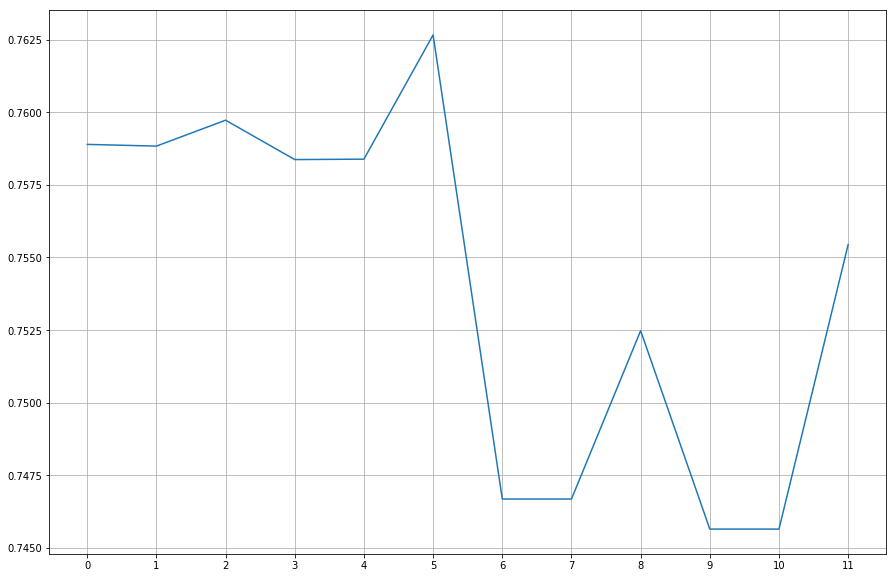

In [52]:
plt.figure(num=None, figsize=(15, 10))
plt.grid()
plt.xticks(range(13))
plt.plot(f1)
plt.show()